In [1]:
%load_ext autoreload
%autoreload 2

# Visualise RNA circuits for Thesis Chapter 2

In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib import font_manager
import RNA
from common import set_theme

set_theme()

PALETTE = 'viridis'

np.random.seed(0)

from evoscaper.utils.visualise import create_network_inset, make_nx_weights


In [3]:
top_dir = os.path.join('figures', '02_rna-circuits')

Load circuits and energies

In [4]:
dir_sim = '../notebooks/data/simulate_circuits/2025_09_23__15_41_51'
fn_circuits = '../data/raw/generate_sequence_batch/2025_09_20_103744/circuits/rc.json'
fn_energies = '../data/raw/generate_sequence_batch/2025_09_20_103744/energies.json'


with open(fn_circuits, 'r') as f:
    circuits = json.load(f)
with open(fn_energies, 'r') as f:
    energies = json.load(f)

In [5]:
energy_keys = sorted(energies.keys(), key=lambda k: int(k.split('_')[1]))

# gather all sequence indices present and determine array width
all_indices = {int(idx) for d in energies.values() for idx in d.keys()}
max_idx = max(all_indices) if all_indices else -1
n_seq = max_idx + 1
n_circuits = len(energy_keys)

# allocate and fill array (missing entries default to 0.0)
energies_arr = np.zeros((n_circuits, n_seq), dtype=float)
for i, k in enumerate(energy_keys):
    ed = energies[k]
    for idx_str, val in ed.items():
        energies_arr[i, int(idx_str)] = float(val)
energies_arr = energies_arr.T

n_species_input = len(circuits.keys())
n_species_bound = len(np.triu_indices(n_species_input)[0])
n_species = n_species_input + n_species_bound

print("energies_arr.shape =", energies_arr.shape)
print("sample (first circuit, first 10):", energies_arr[0, :10])


energies_arr.shape = (1000000, 6)
sample (first circuit, first 10): [0. 0. 0. 0. 0. 0.]


# Visualise

In [6]:
def get_colors(pal, n):
    cmap = cm.get_cmap(pal, n)
    return [cmap(i) for i in range(n)]


def make_pastel(color: tuple) -> tuple:
    r, g, b = color[:3]
    _alpha = 0.4
    pastel_rgb = (1 - _alpha + _alpha * r,
                    1 - _alpha + _alpha * g,
                    1 - _alpha + _alpha * b)
    color = (*pastel_rgb, 1.0)
    return color

/tmp/ipykernel_2141613/1884742533.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(pal, n)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


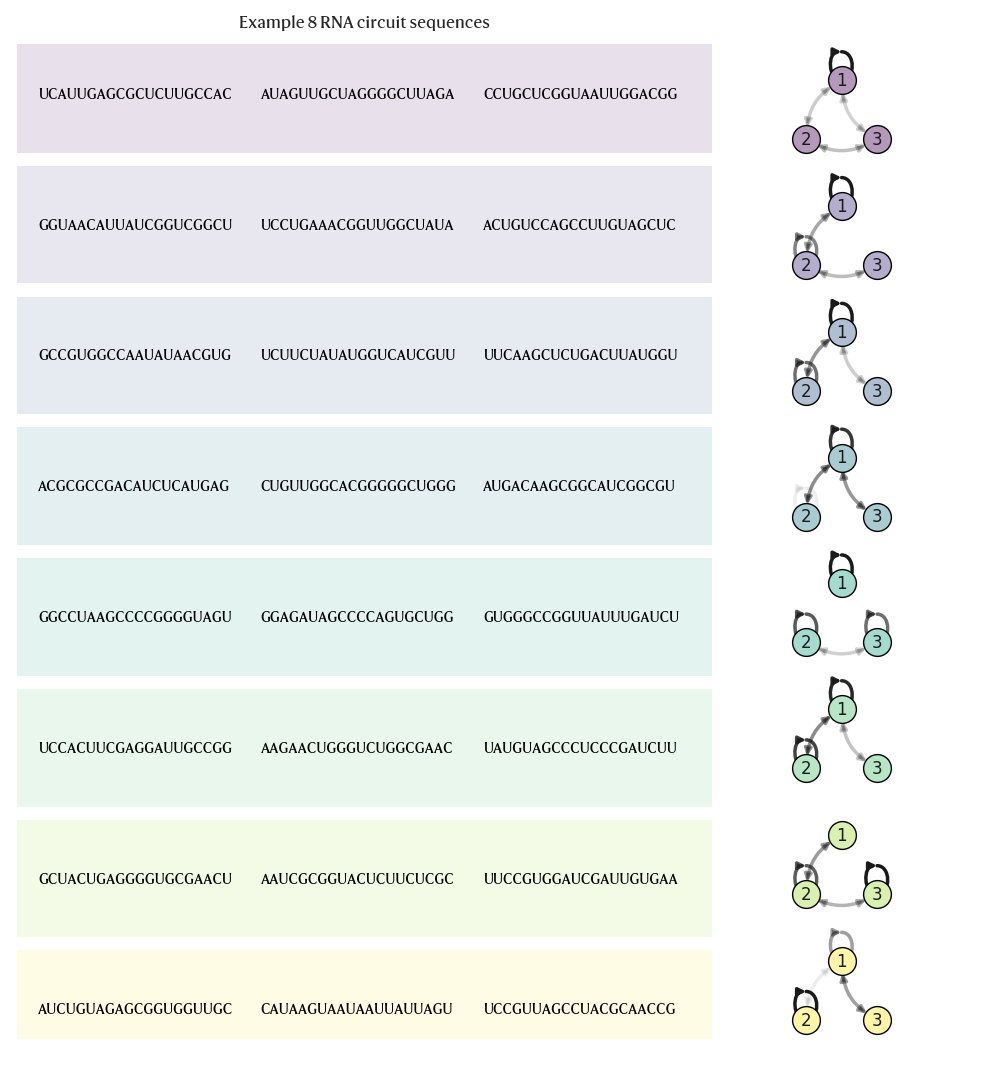

In [25]:
def plot_circuits(circuits, energies_arr: np.ndarray, selected: np.ndarray, cols=None, figsize=(12, 9), fontsize=11,
                  row_alpha=0.12, pad=0.04, pad_networks = 0.01):
    if cols is None:
        cols = list(circuits.columns)
    
    # Slice the first n rows
    df = circuits.iloc[selected].astype(str).reset_index(drop=True)
    e = energies_arr[selected]
    rows = len(df)
    if rows == 0:
        raise ValueError("No rows to plot (maybe `n=0` or `circuits` is empty).")
    
    # Prepare colormap (one color per row)
    colors = get_colors(PALETTE, rows)
    
    # Create figure with two subplots (left: sequences, right: blank for future plotting)
    fig, (ax, ax_2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios':[3, 1]})
    
    # Left axes: draw text grid with 3 columns
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # x positions for the three text columns (in axes coordinates)
    x_positions = [pad, 1/3 + pad/2, 2/3]  # tuned for good spacing; tweak pad if you like
    # compute y positions: evenly spaced from near top to near bottom
    top_margin = 0.95
    bottom_margin = 0.03
    y_positions = np.linspace(top_margin, bottom_margin, rows)
    
    # height for the highlight rectangles (in axes fraction)
    rect_height = (top_margin - bottom_margin) / max(rows - 1, 1) * 0.9
    
    for i, (idx, row) in enumerate(df.iterrows()):
        y = y_positions[i]
        color = colors[i]
        # draw a faint rectangle across the left subplot to highlight the row
        rect = Rectangle((0.01, y - rect_height/2), 0.98, rect_height,
                         transform=ax.transAxes, facecolor=color, alpha=row_alpha, edgecolor='none')
        ax.add_patch(rect)
        # place three texts
        for j, c in enumerate(cols):
            txt = row[c]
            ax.text(x_positions[j], y, txt, transform=ax.transAxes, fontsize=fontsize,
                    va='center', ha='left', color='black')  # black text over tinted background
    
        w = e[i]
        color = make_pastel(colors[i])
        create_network_inset(fig, ax_2,
                            pos=[x_positions[0], y - 0.41 + i*pad_networks],
                            width=0.8, height=0.8, edge_weights=make_nx_weights(w, n_nodes=3), 
                            node_color=color, linewidth=2.5)
            
    ax.set_title(f"Example {rows} RNA circuit sequences", pad=12)
    
    ax_2.axis('off')
    # ax_2.set_title("Corresponding network diagram", pad=12)
    
    plt.tight_layout()
    return fig


# Show the example plot
n = 8
candidates = np.where((energies_arr != 0).sum(axis=1) > 3)[0]
np.random.seed(0)
rand_selected = np.random.choice(candidates.shape[0], size=n, replace=False)
selected = candidates[rand_selected]
df_circuits = pd.DataFrame(circuits)
df_circuits = df_circuits.rename(columns={c: c.replace(c[-1], str(int(c[-1]) + 1)) for c in df_circuits.columns})
fig = plot_circuits(df_circuits, energies_arr, selected, figsize=(10, 11), 
                    fontsize=10, pad_networks=0.005)
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'rna_seqs_networks.png'), dpi=300)
plt.show()


# RNA structure diagrams

In [17]:
idxs_pairs = list(zip(*np.triu_indices(len(circuits.keys()))))
idx_circ = selected[1]
print(df_circuits.iloc[idx_circ].values.tolist())
# for idxs_pair in idxs_pairs:
#     s1 = df_circuits.iloc[idx_circ][df_circuits.columns[idxs_pair[0]]]  # length 20 example
#     s2 = df_circuits.iloc[idx_circ][df_circuits.columns[idxs_pair[1]]]  # length 20 example
    
#     joint_seq = s1 + "&" + s2
#     cofold_result = RNA.cofold(joint_seq)

#     # print(s1, s2, cofold_result[0])
#     print(cofold_result[1])

# --> Now I'm just going to visualise these elsewhere... go to notebook /home/hslab/Olive/Kode/sRNA_design/notebooks/Thesis01_vis_structure.ipynb

['GGUAACAUUAUCGGUCGGCU', 'UCCUGAAACGGUUGGCUAUA', 'ACUGUCCAGCCUUGUAGCUC']


# Time series

In [18]:
ys = np.load(os.path.join(dir_sim, 'ys.npy'))
# y00s = np.load(os.path.join(dir_sim, 'y00s.npy'))
ts = np.load(os.path.join(dir_sim, 'ts.npy'))
# ts0 = np.load(os.path.join(dir_sim, 'ts0.npy'))

582633


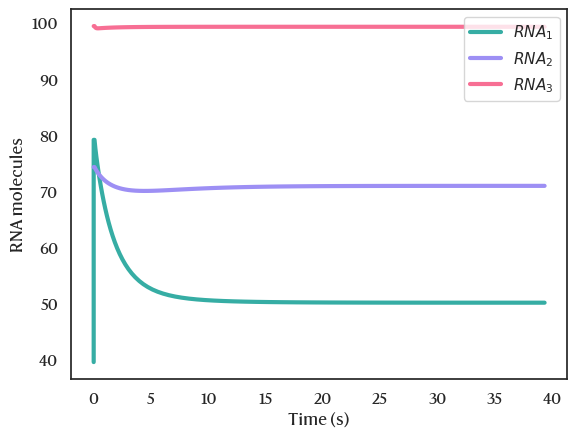

In [38]:
y0m = np.load(os.path.join(dir_sim, 'y0m.npy'))
colors = ['#36ada4', '#9d8ff4', '#f76f94']
idx_circ = selected[2]
tmax = 40
tmax_i = np.argmax(ts > tmax)
y0m[idx_circ, 0, -3] = y0m[idx_circ, 0, -3] / 2
ts_curr = np.concatenate([np.array([0]), ts[:tmax_i]])
ys_curr = np.concatenate((y0m[idx_circ, 0, :][None, :], ys[idx_circ, :tmax_i, :]), axis=0)
del y0m
for i in range(len(df_circuits.columns)):
    plt.plot(ts_curr, ys_curr[:, -(3-i)], color=colors[i], label=f'${df_circuits.columns[i]}$',
             linewidth=3)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('RNA molecules')
# plt.title(f'RNA molecule counts over time for circuit {idx_circ}')
plt.savefig(os.path.join(top_dir, f'rna_circuit_dynamics_{idx_circ}.png'), dpi=300)
print(idx_circ)

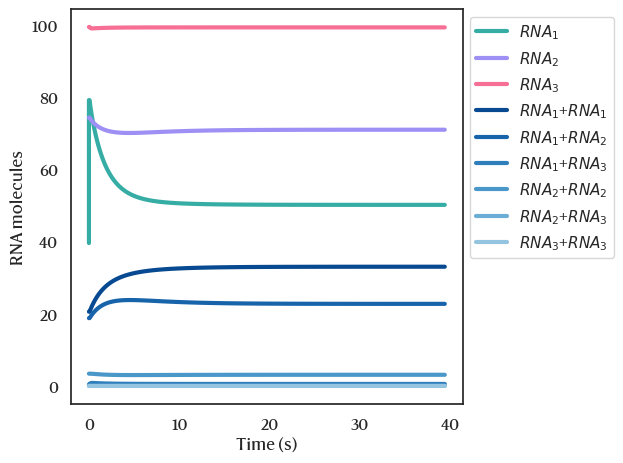

In [37]:
from matplotlib.colors import to_hex

for i in range(len(df_circuits.columns)):
    plt.plot(ts_curr, ys_curr[:, -(3-i)], color=colors[i], label=f'${df_circuits.columns[i]}$',
             linewidth=3)
n_species_input = len(circuits.keys())
n_species_bound = len(np.triu_indices(n_species_input)[0])
n_species = n_species_input + n_species_bound
colors_bound = [to_hex(c) for c in sns.color_palette('Blues', n_colors=n_species_bound + 3)][::-1]
for i, idx_pair in enumerate(list(zip(*np.triu_indices(len(circuits.keys()))))):
    plt.plot(ts_curr, ys_curr[:, i], color=colors_bound[i], 
             label=f'${df_circuits.columns[idx_pair[0]]}$+${df_circuits.columns[idx_pair[1]]}$',
             linewidth=3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Time (s)')
plt.ylabel('RNA molecules')
# plt.title(f'RNA molecule counts over time for circuit {idx_circ}')
plt.tight_layout()
plt.savefig(os.path.join(top_dir, f'rna_circuit_dynamics_{idx_circ}_all.png'), dpi=300,
            bbox_inches='tight')

/tmp/ipykernel_2141613/1884742533.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(pal, n)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

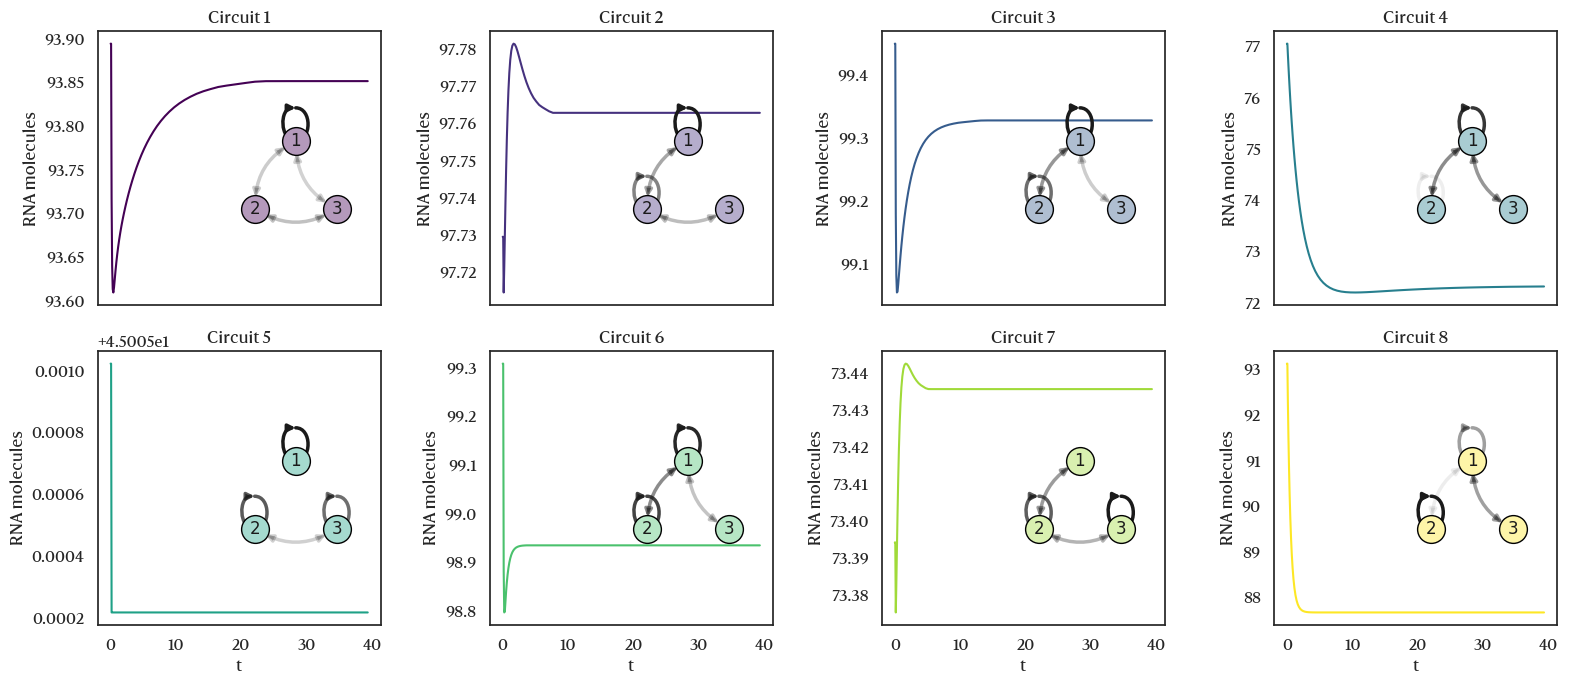

In [21]:

n_species = ys.shape[-1]
df = pd.DataFrame()
df['t'] = (np.ones_like(ys[selected]) * ts[None, :, None]).flatten()
df['RNA molecules'] = ys[selected].flatten()
df['RNA species'] = (np.ones_like(ys[selected]) * np.arange(n_species) + 1).flatten()
# df['RNA species'] = df['RNA species'].astype(str)
df['Circuit'] = (np.ones_like(ys[selected]) * np.arange(n)[:, None, None]).flatten()

colors = get_colors(PALETTE, n)
tmax = 40
# fig, axs = plt.subplots(n, 1, figsize=(4, 3 * n), sharex=True)
nrows = 2
ncols = (n + 1) // 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows), sharex=True)
axs = axs.flatten()
for i, circ in enumerate(df['Circuit'].unique()):
    sns.lineplot(df[(df['Circuit'] == circ) & (df['RNA species'].astype(int) > 8) & (df['t'] <= tmax)], 
                 x='t', y='RNA molecules', # hue='RNA species', 
                 color=colors[i], ax=axs[i], legend=False if i < n - 1 else True)
    w = energies_arr[selected][i]
    color = make_pastel(colors[i])
    create_network_inset(fig, axs[i], pos=[0.3, 0.1],
                        width=0.8, height=0.8, edge_weights=make_nx_weights(w, n_nodes=3), 
                        node_color=color, linewidth=2.5)
    axs[i].set_title(f'Circuit {i+1}')
    
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'rna_dynamics_networks.png'), dpi=300)

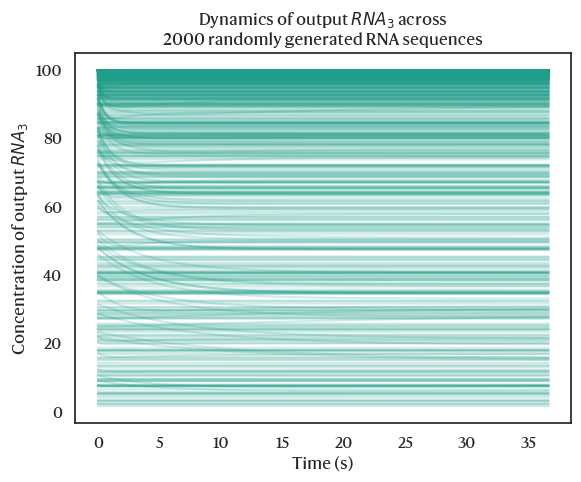

In [22]:
# colors = get_colors(PALETTE, 10)
color = (np.float64(0.119699), np.float64(0.61849), np.float64(0.536347), np.float64(1.0))
tmax = 40
tmax_i = np.where(ts <= tmax)[0][-1]
n_show = 2000
plt.plot(ts[:tmax_i], ys[:n_show, :tmax_i, -1].T, color=color, alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel(f'Concentration of output $RNA_3$')
plt.title(f'Dynamics of output $RNA_3$ across\n{n_show} randomly generated RNA sequences')
plt.savefig(os.path.join(top_dir, 'rna_output_dynamics.png'), dpi=300)

In [23]:
# ys_full_i = np.concatenate([y00s[selected], ys[selected]], axis=1)
# ts_full = np.concatenate([ts0, ts], axis=0)

In [24]:
# plt.plot(ts_full, ys_full_i[0, :, -1])